In [112]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

In [113]:
data = pd.read_csv('s3://helen-ml/week-4/AirPassengers.csv', index_col=0)
data.head()

time  value
1  1949.000000    112
2  1949.083333    118
3  1949.166667    132
4  1949.250000    129
5  1949.333333    121

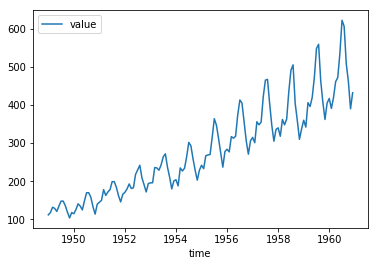

In [114]:
data.set_index('time').plot()
plt.show()

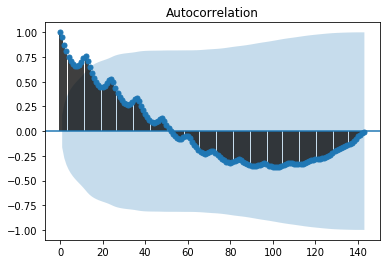

In [115]:
plot_acf(data.set_index('time')['value'])
plt.show()

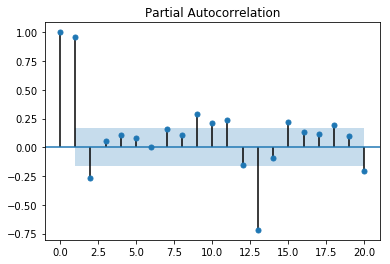

In [116]:
plot_pacf(data.set_index('time')['value'], lags=20)
plt.show()

# Model is not stationary - use differencing

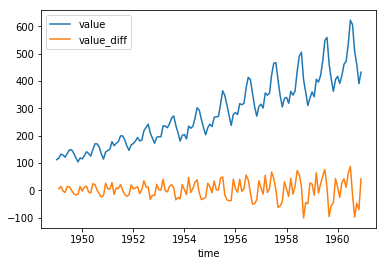

In [117]:
data.set_index('time', inplace=True)
data['value_diff'] = data['value'].diff()

data.plot()
plt.show()

# Trend was removed, but variance is not constant - transform using log()

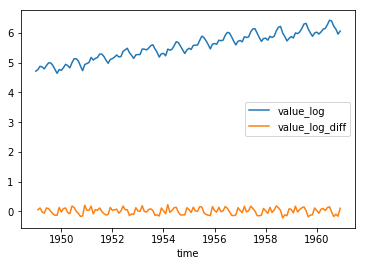

In [118]:
data['value_log'] = data['value'].apply(lambda x: math.log(x))
data['value_log_diff'] = data['value_log'].diff()

data[['value_log', 'value_log_diff']].plot()
plt.show()

In [119]:
data.head()

value  value_diff  value_log  value_log_diff
time                                                     
1949.000000    112         NaN   4.718499             NaN
1949.083333    118         6.0   4.770685        0.052186
1949.166667    132        14.0   4.882802        0.112117
1949.250000    129        -3.0   4.859812       -0.022990
1949.333333    121        -8.0   4.795791       -0.064022

In [120]:
# we cannot calculate a diff for the first row, so we need
# to skip the NaN values
data_nn = data[data.value_log_diff.notnull()]

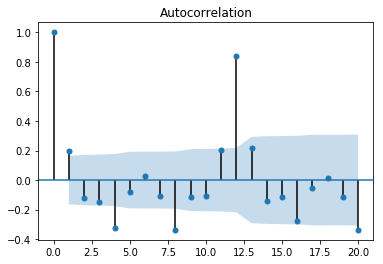

In [121]:
plot_acf(data_nn['value_log_diff'], lags=20)
plt.show()

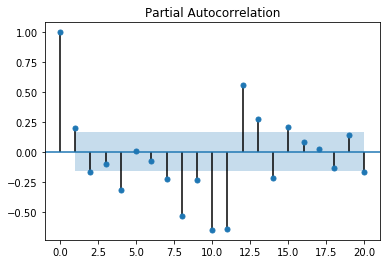

In [122]:
plot_pacf(data_nn['value_log_diff'], lags=20)
plt.show()

# 2nd order auto-regression is likely: coefficients after the 2nd one are <0

# split into training and test sets

In [123]:
split_index = int(2/3 * len(data_nn))
print('Data set size: %s' % len(data_nn))
print('Split at: %s' % split_index)
training = data_nn.iloc[:split_index]
test = data_nn.iloc[split_index+1:]

print("Training:")
print(training.head())
print("Test:")
print(test.head())

Data set size: 143
Split at: 95
Training:
             value  value_diff  value_log  value_log_diff
time                                                     
1949.083333    118         6.0   4.770685        0.052186
1949.166667    132        14.0   4.882802        0.112117
1949.250000    129        -3.0   4.859812       -0.022990
1949.333333    121        -8.0   4.795791       -0.064022
1949.416667    135        14.0   4.905275        0.109484
Test:
             value  value_diff  value_log  value_log_diff
time                                                     
1957.083333    301       -14.0   5.707110       -0.045462
1957.166667    356        55.0   5.874931        0.167820
1957.250000    348        -8.0   5.852202       -0.022728
1957.333333    355         7.0   5.872118        0.019915
1957.416667    422        67.0   6.045005        0.172888


In [124]:
model = AR(training['value_log_diff'].values)
model_fit = model.fit(2)

print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 2
Coefficients: [ 0.00950802  0.19063787 -0.20094318]


In [125]:
predictions = model_fit.predict(start=len(training), end=len(training)+len(test)-1, dynamic=True)
predictions_df = pd.DataFrame(predictions, columns=['forecast_log_diff'], index=test.index)

In [130]:
results = test.join(predictions_df)

# from diffs back to "undiffed" data...
results.loc[:, 'undiffed'] = results.loc[:, 'forecast_log_diff'].cumsum(0) + data.iloc[split_index - 1]['value_log']
# ... and then exponentiate to get back a comparable time series
results.loc[:, 'forecast'] = results.loc[:, 'undiffed'].apply(lambda x: np.exp(x))

results.head()

value  value_diff  value_log  value_log_diff  forecast_log_diff  \
time                                                                           
1957.083333    301       -14.0   5.707110       -0.045462           0.057072   
1957.166667    356        55.0   5.874931        0.167820          -0.004020   
1957.250000    348        -8.0   5.852202       -0.022728          -0.002727   
1957.333333    355         7.0   5.872118        0.019915           0.009796   
1957.416667    422        67.0   6.045005        0.172888           0.011923   

             undiffed    forecast  
time                               
1957.083333  5.659191  286.916356  
1957.166667  5.655171  285.765343  
1957.250000  5.652444  284.987263  
1957.333333  5.662240  287.792711  
1957.416667  5.674164  291.244710

In [132]:
mse = mean_squared_error(results['value'].values, results['forecast'].values)
rmse = math.sqrt(mse)

print('RMSE: %f' % rmse)

RMSE: 91.462371


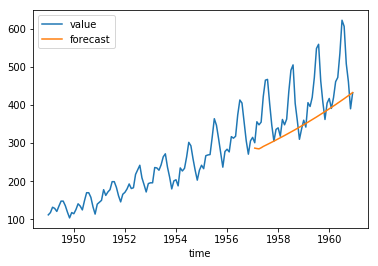

In [138]:
data_2 = data.join(results['forecast'])

data_2[['value', 'forecast']].plot()
plt.show()